Zofia Maszlanka s22555 <br>
Tomasz Latała s23864

In [34]:
!python -m pip install -U spacy
!python -m spacy download pl_core_news_md
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 87.9 MB 22 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_md')
     |████████████████████████████████| 58.6 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [35]:
!python -m pip install emoji


import pandas as pd
import numpy as np
import string
import spacy
import re
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split




In [36]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
path = '/content/drive/MyDrive/tweets.csv'

In [38]:
dataset = pd.read_csv(path, sep='\t', header = None, names = ['tweet'])

In [39]:
dataset.head(100)

,tweet
0,Podejrzenie wirusa Coronavirus https://t.co/Zb...
1,Boję się tego wirusa hshshshshs #coronavirus
2,Pierwszy przypadek wirusa #2019nCoV w Kaliforn...
3,"Kiedy #coronavirus dotrze do Polski, napotka o..."
4,Prawdopodobnie nie uchroni od #coronavirus ale...
...,...
95,@SzumowskiLukasz może być potrzebne zawierzeni...
96,https://t.co/yCUbccUcmH Nie trzeba #coronaviru...
97,Sanepid o koronawirusie: nie ma powodów do pan...
98,"Forma wyrażania gniewu, protestu... Do Wuhan p..."


In [40]:
len(dataset)

307692

In [41]:
def preprocess(text):
 
  text = text.str.lower()

  nlp = spacy.load('pl_core_news_md')
  stopwordlist = nlp.Defaults.stop_words
  def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])

  punctuations_list = string.punctuation
  def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list) 
    return text.translate(translator)

  to_remove = [' rt ', 'icymi', 'wuhan', 'koronawirus ', 'wirus ', 'coronavirus '] #means retweet, in case you missed it
  def cleaning_xdd(text):
    return re.sub(r'x(d)\1+', r'', text)

  def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

  def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

  def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

  def cleaning_emojis(text):
    return emoji.get_emoji_regexp().sub(u'', text)

  def cleaning_usernames(data):
    return re.sub('@(.*?)($|\s)', '', data)


  text = text.map(lambda x: cleaning_stopwords(x)) 
  text = text.map(lambda x: cleaning_xdd(x))
  for word in to_remove:
    text = text.map(lambda x: x.replace(word, ''))
  text = text.map(lambda x: cleaning_repeating_char(x))
  text = text.map(lambda x: cleaning_URLs(x))
  text = text.map(lambda x: cleaning_numbers(x))
  text = text.map(lambda x: cleaning_emojis(x))
  text = text.map(lambda x: cleaning_usernames(x))
  text = text.map(lambda x: cleaning_punctuations(x))
 
  return(text)




In [ ]:
dataset['tweet'] = preprocess(dataset['tweet'])

In [ ]:
nlpPL = spacy.load('pl_core_news_sm')
def lemmatization(data):
  text = nlpPL(data)
  return(" ".join([token.lemma_ for token in text]))

In [44]:
dataset['tweet'] = dataset['tweet'].apply(lambda x: lemmatization(x))
dataset.head(10)

,tweet
0,podejrzenie wirus spdtgq
1,bać wirus hshshshshs coronavirus
2,pierwszy przypadek wirus ncov kalifornii trzec...
3,dotrze polski napotka opora znakomicie zorgani...
4,prawdopodobnie uchronić zapewnić ochrona twarz...
5,lekceważcie daleko tragedia
6,msz przygotowywać ewakuacja polak chiński s...
7,pomylić liczbowo milion mieszkaniec o procen...
8,federalny msz niemiec ogłosić zamiar ewakuacja...
9,monkaw


In [45]:
to_remove = ['koronawirus', 'wirus', 'coronavirus'] 
for word in to_remove:
  dataset['tweet'] = dataset['tweet'].map(lambda x: x.replace(word, ''))
dataset.dropna()
dataset.drop_duplicates()

,tweet
0,podejrzenie spdtgq
1,bać hshshshshs
2,pierwszy przypadek ncov kalifornii trzeci usa...
3,dotrze polski napotka opora znakomicie zorgani...
4,prawdopodobnie uchronić zapewnić ochrona twarz...
...,...
307687,teleexpress szczepionka przeciw covid dotrze...
307688,pielęgniarka szpital mswia pierwszy osoba pols...
307689,niezwykle niezwykły sukces komunistyczny chińs...
307690,rosyjski szczepionka przeciw covid zezwolić sz...


In [46]:
len(dataset)

307692

In [47]:
dataset.head(100)

,tweet
0,podejrzenie spdtgq
1,bać hshshshshs
2,pierwszy przypadek ncov kalifornii trzeci usa...
3,dotrze polski napotka opora znakomicie zorgani...
4,prawdopodobnie uchronić zapewnić ochrona twarz...
...,...
95,potrzebny zawierzenie student opieka matka bos...
96,s daleko krakowie przedwcześnie umrzeć tyś ...
97,sanepid ie powód panika ska syahl
98,forma wyrażania gniew protest przyjść honkon...


In [48]:
vectorizer = TfidfVectorizer(ngram_range=(1,2)) #unigramy i bigramy
vectorizer.fit(dataset['tweet'])
print('Featured words: ', len(vectorizer.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Featured words:  2080564


In [49]:
dataset_v = vectorizer.transform(dataset['tweet'])

In [50]:
print(dataset_v.shape)
print(dataset.shape)

(307692, 2080564)
(307692, 1)


In [51]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(dataset_v)
pred = kmeans.predict(dataset_v)


In [52]:
unique, counts = np.unique(pred, return_counts=True)
for i in range (3):
  print(unique[i], " : ", counts[i])

0  :  226718
1  :  12172
2  :  68802


In [53]:
df = pd.DataFrame(pred)
dataset = dataset.join(df)
dataset0 = dataset[dataset[0] == 0]
dataset1 = dataset[dataset[0] == 1]
dataset2 = dataset[dataset[0] == 2]

In [54]:
dataset0.head(100)

,tweet,0
0,podejrzenie spdtgq,0
1,bać hshshshshs,0
2,pierwszy przypadek ncov kalifornii trzeci usa...,0
3,dotrze polski napotka opora znakomicie zorgani...,0
4,prawdopodobnie uchronić zapewnić ochrona twarz...,0
...,...,...
97,sanepid ie powód panika ska syahl,0
98,forma wyrażania gniew protest przyjść honkon...,0
99,gówno normalny przeziębionko em azji dusiciel,0
100,zainteresowany wierzytelny informacja temat za...,0


In [55]:
dataset1.head(100)

,tweet,0
28,portugalia pierwszy pacjent podejrzenie zakaże...,1
48,osoba zemrzeć zaatakować sri lanka państwo ...,1
313,groźny objaw zrobić przypadek zakażenie,1
314,bilans potwierdzone przypadek z czego chi...,1
386,kolejny osoba podejrzenie,1
...,...,...
7316,irancovi iranie nowy przypadek kolejny ofi...,1
7345,el país hiszpański walencja potwierdzić kolejn...,1
7352,zalecenie pacjent związek zagrożenie zakażenie...,1
7359,korei południowy nowy potwierdzonych przypadek...,1


In [56]:
dataset2.head(100)

,tweet,0
366,polsce,2
520,rzeczpospolita amerykan pracować szczepionka p...,2
2543,wytworzona szczepionka przeciwko,2
2717,polski s,2
3956,covid wg who szczepionka rok,2
...,...,...
7344,covid szaleć włoszech fabryka ducati piaggio h...,2
7356,japan osoba zarażony ofiara śmiertelny oso...,2
7360,premiera australii wskazywać to wybuchnie pand...,2
7377,walka epidemią skomplikować covid wrócić wylec...,2


In [57]:
X_train, X_test, y_train, y_test = train_test_split(dataset['tweet'], dataset[0], test_size = 0.2, random_state =42)

In [58]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

246153
246153
61539
61539


In [59]:
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectorizer.fit(X_train)
def vectorize(x):
  return vectorizer.transform(x)

In [60]:
X_train_v = vectorize(X_train)
X_test_v = vectorize(X_test)

In [61]:
def model_Evaluate(model):
  
  y_pred = model.predict(X_test_v)

  print(classification_report(y_test, y_pred))

  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, cmap = 'Blues',fmt = '', annot = True)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# **SVC**

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45283
           1       0.86      0.97      0.91      2411
           2       0.95      0.99      0.97     13845

    accuracy                           0.98     61539
   macro avg       0.94      0.98      0.96     61539
weighted avg       0.98      0.98      0.98     61539



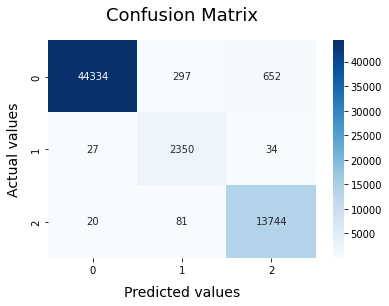

In [62]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_v, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test_v)

# **LRmodel**

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train_v, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test_v)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     45283
           1       0.89      0.97      0.93      2411
           2       0.95      1.00      0.97     13845

    accuracy                           0.98     61539
   macro avg       0.95      0.98      0.96     61539
weighted avg       0.98      0.98      0.98     61539



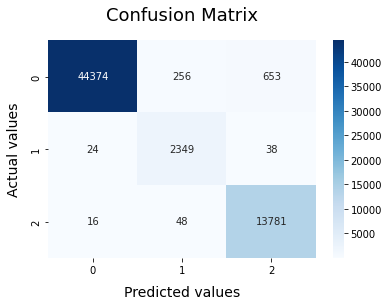

In [66]:
model_Evaluate(LRmodel)

# **Random Forest**

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45283
           1       0.87      0.87      0.87      2411
           2       0.95      0.88      0.91     13845

    accuracy                           0.96     61539
   macro avg       0.93      0.91      0.92     61539
weighted avg       0.96      0.96      0.96     61539



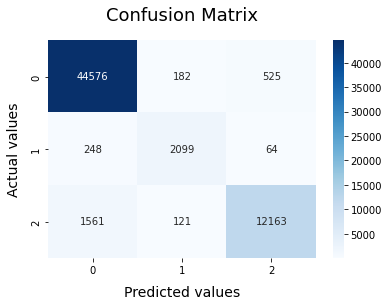

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train_v, y_train)
model_Evaluate(rf_classifier)
y_pred_rf = rf_classifier.predict(X_test_v)